In [3]:
# the goal in this notebook is to visualize the filters of the simple CNN model

# import libraries necessary for building the CNN
import numpy as np
import keras
from keras.layers import Input, Conv2D, Dense, Activation, Flatten
from keras.models import Sequential
from keras.datasets import mnist

Using TensorFlow backend.
/Users/chloeloughridge/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [4]:
# for plotting the model
# !pip install pydot
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [ ]:
# important variables
num_classes = 10 # one for each of the digits from 0-9
batch_size = 128 #tunable number
epochs = 13 #tunable number

In [ ]:
# import mnist data from keras
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# reshape the x data do it's 4 dimensional --> the last dimension represents color channels
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# we need to normalize the X data before feeding into our model
X_train = X_train/255
X_test = X_test/255

# we also need to convert the Y data into one-hot vectors
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)


In [ ]:
# building the architecture of the convolutional model
model = Sequential() #this will allow us to build a linear stack of layers --> hmmm is this restrictive in any way?
                    # we may not want to limit folks to only a linear stack of layers, because this could
                    # prevent them from making cool skip connections and stuff like that . . . something to consider
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape = (28,28, 1)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=['accuracy'])

In [ ]:
# train the model on the training data
model.fit(X_train, Y_train, batch_size = batch_size, epochs=epochs, verbose=1, validation_data=(X_test, Y_test))

In [5]:
model = keras.models.load_model("./CNN01")

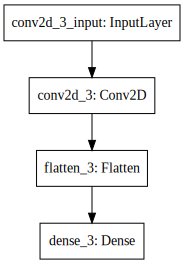

In [6]:
#import pydot
#plot_model(model, to_file='model01.png')
SVG(model_to_dot(model).create(prog='dot', format="svg"))

In [7]:
# going to visualize the filters of the model  . . . 
# inspiration from here: https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

# create a dictionary of the model's layers
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [166]:
from keras import backend as K #the backend in this case is tensorflow, since keras is sitting on top of it
                                #so importing the "backend" will allow us to write code in tensorflow that keras
                                #will be able to use for our model
        
#we'll be sending in an image the size of one of the MNIST images
img_width = 28
img_height = 28
        
layer_name = "conv2d_3"
filter_index = 0 #there are 32 filters, so this could be any number in the range 0-31

# create a loss function that we will use to maximize the activation of the specified layer
layer_output = layer_dict[layer_name].output # accesing the output of the specified layer stored in our dictionary
loss = K.mean(layer_output[:,:,:, filter_index]) # averaging all the outputs of the filter --> remember that the filter
                                                # is a 2-D "square" --> the middle two numbers represent height/width
                                                # of that square, the first number represents batch size, and the 
                                                # final number represents the number of filters (we're accessing a
                                                # specific one here)
# compute the gradient of the input picture with respect to this loss.
# this means we'll be updating the pixels of the input image, not the weights of the network --> clever!
grads = K.gradients(loss, model.input)[0] # I don't know what the [0] means at the end of this line
print(grads)

# normalizing the gradient --> we don't want the magnitude of our gradient ascent/descent step to be infuenced heavily 
# by the gradient --> the gradient gives us the direction we want to take --> so normalizing helps the optimization
# algorithm perform better
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([model.input], [loss, grads]) # this is a fancy way of writing a custom function that takes
                                                # an input image as an input, and returns the loss and gradients
                                                # for that image


Tensor("gradients_40/conv2d_3/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)


In [167]:
# running gradient ascent to maximize the activations of the filter

# generating a grey test image
input_img = np.random.random((1, img_width, img_height, 1)) * 20 + 128.

# Choosing an arbitrary value for "step" --> pretty sure this is like the learning rate
step = 5

# 20 steps of gradient ascent
for i in range(50):
    loss_value, grads_value = iterate([input_img])
    input_img += grads_value * step


In [168]:
# creating a function to deprocess the image 
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to black/white representation
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


(1, 28, 28, 1)


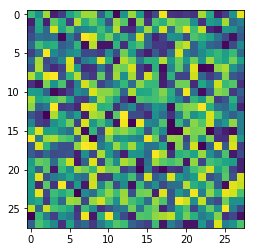

In [169]:
# saving the image as a file
img = input_img
img = deprocess_image(img)

# the imsave approach
#imsave('%s_filter_%d.png' % (layer_name, filter_index), img)
print(img.shape)


# the matplotlib approach
import matplotlib.pyplot as plt
plt.imshow(img.squeeze())
plt.show()